### Data Preprocessing

This file contains all functions and classes for the pre-processing of the data

In [254]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import warnings 
warnings.filterwarnings('ignore')

In [255]:
#importing the dataset
data = pd.read_csv('./data/bank-additional-full.csv', sep=";")

#### Aggregating columns to reduce variance

In [256]:
#Aggregate the pdays column - number of days that passed by after the client was last contacted from a previous campaign 
def aggregate_column(x):
    if x == 999:
       return 'Not Previously Contacted'
    elif x >= 0 & x <= 7:
       return '1 week'
    elif x > 7 & x <= 14:
       return '2 weeks'
    elif x > 14 & x < 21:
       return '3 weeks'
    else:
       return '4 weeks'

data['pdays'] = data['pdays'].apply(aggregate_column)


In [257]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,Not Previously Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,Not Previously Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,Not Previously Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,Not Previously Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,Not Previously Contacted,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [258]:
#getting the numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = data.select_dtypes(include=numerics)
numerical_feature = newdf.columns
numerical_feature

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

#### One Hot Encoding for all categorical data

In [259]:
#getting the categorical variables
categorical_features = data.select_dtypes(include=[np.object])
categorical_feature=categorical_features.columns
categorical_feature

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'pdays', 'poutcome', 'y'],
      dtype='object')

In [260]:
#encoding categorical data with one hot encoding
encoder = OneHotEncoder(sparse=False)
for feature in categorical_feature:
    data[feature] = encoder.fit_transform(data[feature].values.reshape(-1, 1))
    

In [261]:
type(data)

pandas.core.frame.DataFrame

#### Outlier Treatment using Isolation Forest - a tree-based anomaly detection algorithm.

In [262]:
#creating a copy of data
data_copy = data.copy()

In [263]:
#selecting the columns to remove outliers from
#from the EDA, the columns with outliers - Age, Campaign, duration
out_list = ['pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
outliers = [x for x in newdf.columns if x not in out_list]
outliers

['age', 'duration', 'campaign']

In [264]:
# identify outliers in the training dataset
for feature in outliers:
    iso = IsolationForest(contamination=0.1)
    #the predicted anomalies have a -1 anomaly score predicted
    data['anomaly'] = iso.fit_predict(data[feature].values.reshape(-1, 1))
    data=data[data['anomaly'] != -1]
    
    

In [265]:
#checking the shape
data.shape

(30893, 22)

In [266]:
#dropping the anomaly column
data = data.drop('anomaly', axis=1)

In [267]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,0.0,0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0
1,57,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1,0.0,0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0
2,37,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1,0.0,0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0
3,40,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1,0.0,0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0
4,56,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,0.0,0,0.0,1.1,93.994,-36.4,4.857,5191.0,1.0


#### Normalization using MinMaxScaler 

In [268]:
for feature in numerical_feature:
    #creating a nminmax scaler instance
    scaler = MinMaxScaler()
    data[feature] = scaler.fit_transform(data[feature].values.reshape(-1, 1))

In [269]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.935484,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0
1,0.967742,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0
2,0.322581,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0
3,0.419355,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0
4,0.935484,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.9375,0.698753,0.60251,0.957379,0.859735,1.0


#### Principal Component Analysis for Dimensionality Reduction

In [270]:
feat_cols = [x for x in data.columns if x not in ['y']]
feat_cols

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [271]:
pca = PCA()
processed_data = pd.DataFrame(pca.fit_transform(data[feat_cols].values), columns=feat_cols)


In [272]:
processed_data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,-0.771821,0.512852,0.329542,0.197132,-0.328973,-0.167373,-0.022621,0.153255,1.006157,0.183775,0.094315,-0.085543,-0.001605,0.054714,-0.019124,-0.061955,-0.023918,-0.016454,0.024018,-0.004324
1,-0.913944,0.460678,0.526455,0.036025,0.287619,-0.529737,-0.101356,-0.001303,-0.040178,0.111283,-0.236855,-0.497581,0.017882,-0.106278,-0.006364,-0.035523,-0.031252,-0.010864,0.025377,-0.003826
2,-0.562696,-0.445925,-0.000751,0.343695,-0.539179,-0.110972,-0.164069,-0.147116,-0.011440,0.143596,-0.201446,-0.045497,-0.012127,0.033620,0.003109,-0.086467,-0.028138,-0.011042,0.020652,-0.003655
3,-0.593915,0.545885,-0.810859,0.191628,-0.084914,-0.396733,-0.069920,-0.099452,0.165560,0.179977,-0.140455,-0.104372,0.023302,-0.105248,-0.008298,-0.051154,-0.020638,-0.012293,0.024351,-0.004444
4,-0.704892,0.359598,0.078620,0.306690,-0.211861,-0.018687,0.938146,0.082809,0.214974,0.136579,-0.184353,-0.546966,0.097720,0.149032,-0.050708,-0.037905,-0.022128,-0.016165,0.022424,-0.004367


In [276]:
processed_data.shape

(30893, 20)

In [277]:
data.y.shape

(30893,)

In [281]:
processed_data['y'] = data['y'].values

In [282]:
processed_data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### Train, Test Split - Split the data using 90% for training and 10% for testing

In [283]:
X = processed_data.drop(columns=["y"])
y = processed_data['y']
print(X.shape)
print(y.shape)

(30893, 20)
(30893,)


In [284]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)

In [285]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(27803, 20)
(27803,)
(3090, 20)
(3090,)


### Machine Learning Models

#### Evaluation Metrics

In [329]:
def eval_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary') 
    recall = recall_score(y_test, y_pred, average='binary')
    score = f1_score(y_test, y_pred, average='binary')
    print('Accuracy: %.3f' % accuracy)
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('F1-Score: %.3f' % score)



In [345]:
from sklearn.metrics import roc_curve
def the_roc_curve(y_test, y_pred, pred, name):
    logit_roc_auc = roc_auc_score(y_test, pred)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    plt.figure()
    plt.plot(fpr, tpr, label=name+ '(area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
   # plt.savefig('Log_ROC')
    plt.show()

#### Machine Learning Models - Stratified K-Fold Cross Validation

#### 1. Logistic Regression

In [385]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression(C=2)
    lr.fit(xtr,ytr)
    score = accuracy_score(yvl, lr.predict(xvl))
    print('Accuracy Score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1
    


1 of KFold 5
Accuracy Score: 0.946925566343042
2 of KFold 5
Accuracy Score: 0.9461077844311377
3 of KFold 5
Accuracy Score: 0.94512787309809
4 of KFold 5
Accuracy Score: 0.9418905794755584
5 of KFold 5
Accuracy Score: 0.9446422790547102


In [393]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean Accuracy Score',np.mean(cv_score))
print(classification_report(yvl,lr.predict(xvl)))

Confusion matrix
 [[ 160  262]
 [  80 5676]]
Cv [0.9474110032362459, 0.9464314614015212, 0.9457753318225963, 0.9425380382000648, 0.9446422790547102] 
Mean Accuracy Score 0.9453596227430276
              precision    recall  f1-score   support

         0.0       0.67      0.38      0.48       422
         1.0       0.96      0.99      0.97      5756

    accuracy                           0.94      6178
   macro avg       0.81      0.68      0.73      6178
weighted avg       0.94      0.94      0.94      6178



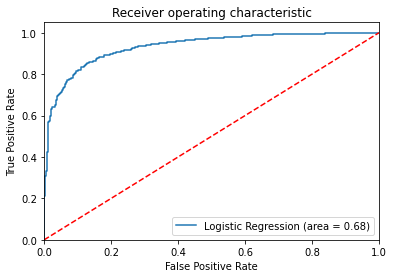

In [389]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(yvl, lr.predict(xvl))
fpr, tpr, thresholds = roc_curve(yvl, lr.predict_proba(xvl)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

#### 2.XGBoost Classifier

In [403]:
from xgboost import XGBClassifier
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    xgb = XGBClassifier()
    xgb.fit(xtr,ytr)
    score = accuracy_score(yvl, xgb.predict(xvl))
    print('Accuracy Score:',score)
    cv_score.append(score)    
    pred_test = xgb.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1
    


1 of KFold 5
Accuracy Score: 0.9475728155339805
2 of KFold 5
Accuracy Score: 0.9490208771645897
3 of KFold 5
Accuracy Score: 0.9477177079961152
4 of KFold 5
Accuracy Score: 0.9452897377792165
5 of KFold 5
Accuracy Score: 0.9464227905471027


In [404]:
print('Confusion matrix\n',confusion_matrix(yvl,xgb.predict(xvl)))
print('Cv',cv_score,'\nMean Accuracy Score',np.mean(cv_score))
print(classification_report(yvl,xgb.predict(xvl)))

Confusion matrix
 [[ 180  242]
 [  89 5667]]
Cv [0.9475728155339805, 0.9490208771645897, 0.9477177079961152, 0.9452897377792165, 0.9464227905471027] 
Mean Accuracy Score 0.9472047858042011
              precision    recall  f1-score   support

         0.0       0.67      0.43      0.52       422
         1.0       0.96      0.98      0.97      5756

    accuracy                           0.95      6178
   macro avg       0.81      0.71      0.75      6178
weighted avg       0.94      0.95      0.94      6178



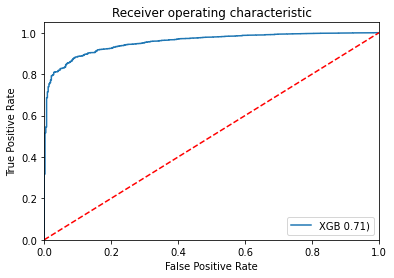

In [412]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(yvl, xgb.predict(xvl))
fpr, tpr, thresholds = roc_curve(yvl, xgb.predict_proba(xvl)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#lt.savefig('Log_ROC')
plt.show()

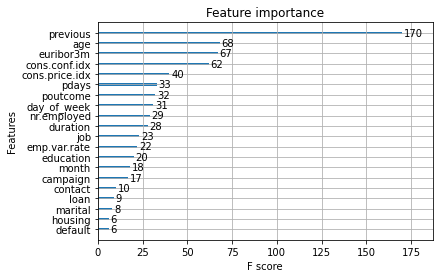

In [396]:
#feature importances
from xgboost import plot_importance
#plot feature importance
plot_importance(xgb)
plt.show()

#### 3. Support Vector Machine

In [407]:
from sklearn.svm import SVC
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
pred_test_full =0
cv_score =[]
i=1
#kernel = ["linear", "rbf", "poly"]
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    # create model
    model = SVC(kernel = 'linear', C = 1.0)
    model.fit(xtr,ytr)
    score = accuracy_score(yvl, model.predict(xvl))
    print('Accuracy Score:',score)
    cv_score.append(score)    
    i+=1
    

1 of KFold 5
Accuracy Score: 0.9368932038834952
2 of KFold 5
Accuracy Score: 0.9409289529050008
3 of KFold 5
Accuracy Score: 0.9342829394626092
4 of KFold 5
Accuracy Score: 0.9373583684040142
5 of KFold 5
Accuracy Score: 0.9384914211719003


In [402]:
print('Confusion matrix\n',confusion_matrix(yvl,model.predict(xvl)))
print('Cv',cv_score,'\nMean Accuracy Score',np.mean(cv_score))
print(classification_report(yvl,model.predict(xvl)))


Confusion matrix
 [[ 111  311]
 [  69 5687]]
Cv [0.9474110032362459, 0.9464314614015212, 0.9457753318225963, 0.9425380382000648, 0.9446422790547102] 
Mean Accuracy Score 0.9453596227430276
              precision    recall  f1-score   support

         0.0       0.62      0.26      0.37       422
         1.0       0.95      0.99      0.97      5756

    accuracy                           0.94      6178
   macro avg       0.78      0.63      0.67      6178
weighted avg       0.93      0.94      0.93      6178



#### 4.Random Forest

In [406]:
from xgboost import XGBClassifier
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    rfc_model = RandomForestClassifier()
    rfc_model.fit(xtr,ytr)
    score = accuracy_score(yvl, rfc_model.predict(xvl))
    print('Accuracy Score:',score)
    cv_score.append(score)    
    pred_test = rfc_model.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1
    


1 of KFold 5
Accuracy Score: 0.9420711974110032
2 of KFold 5
Accuracy Score: 0.943032853212494
3 of KFold 5
Accuracy Score: 0.9423761735189382
4 of KFold 5
Accuracy Score: 0.936710909679508
5 of KFold 5
Accuracy Score: 0.940919391388799


In [408]:
print('Confusion matrix\n',confusion_matrix(yvl,rfc_model.predict(xvl)))
print('Cv',cv_score,'\nMean Accuracy Score',np.mean(cv_score))
print(classification_report(yvl,rfc_model.predict(xvl)))

Confusion matrix
 [[ 203  219]
 [ 146 5610]]
Cv [0.9368932038834952, 0.9409289529050008, 0.9342829394626092, 0.9373583684040142, 0.9384914211719003] 
Mean Accuracy Score 0.9375909771654038
              precision    recall  f1-score   support

         0.0       0.58      0.48      0.53       422
         1.0       0.96      0.97      0.97      5756

    accuracy                           0.94      6178
   macro avg       0.77      0.73      0.75      6178
weighted avg       0.94      0.94      0.94      6178



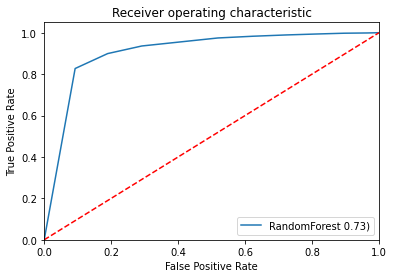

In [411]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(yvl, rfc_model.predict(xvl))
fpr, tpr, thresholds = roc_curve(yvl, rfc_model.predict_proba(xvl)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RandomForest %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#lt.savefig('Log_ROC')
plt.show()

#### 5.Decision Trees

In [413]:

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    clf_decision_model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
    clf_decision_model.fit(xtr,ytr)
    score = accuracy_score(yvl,  clf_decision_model.predict(xvl))
    print('Accuracy Score:',score)
    cv_score.append(score)    
    pred_test =  clf_decision_model.predict_proba(X_test)[:,1]
    pred_test_full +=pred_test
    i+=1

1 of KFold 5
Accuracy Score: 0.9388349514563107
2 of KFold 5
Accuracy Score: 0.9376921832011652
3 of KFold 5
Accuracy Score: 0.9391388798964067
4 of KFold 5
Accuracy Score: 0.9360634509550017
5 of KFold 5
Accuracy Score: 0.9404337973454192


In [414]:
print('Confusion matrix\n',confusion_matrix(yvl, clf_decision_model.predict(xvl)))
print('Cv',cv_score,'\nMean Accuracy Score',np.mean(cv_score))
print(classification_report(yvl, clf_decision_model.predict(xvl)))

Confusion matrix
 [[  96  326]
 [  42 5714]]
Cv [0.9388349514563107, 0.9376921832011652, 0.9391388798964067, 0.9360634509550017, 0.9404337973454192] 
Mean Accuracy Score 0.9384326525708607
              precision    recall  f1-score   support

         0.0       0.70      0.23      0.34       422
         1.0       0.95      0.99      0.97      5756

    accuracy                           0.94      6178
   macro avg       0.82      0.61      0.66      6178
weighted avg       0.93      0.94      0.93      6178



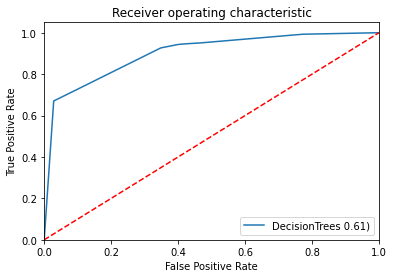

In [415]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(yvl,  clf_decision_model.predict(xvl))
fpr, tpr, thresholds = roc_curve(yvl,  clf_decision_model.predict_proba(xvl)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DecisionTrees %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#lt.savefig('Log_ROC')
plt.show()

#### Machine Learning Models - K-Fold Cross Validation

#### 1.Logistic Regression

In [366]:
from numpy import mean
from numpy import std

#prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model_kfold = LogisticRegression()
# evaluate model
scores = cross_val_score(model_kfold, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.945 (0.002)


In [367]:
model_kfold.fit(X_train, y_train)
pred = model_kfold.predict(X_test)
eval_metrics(y_test, pred)


Accuracy: 0.945
Precision: 0.955
Recall: 0.987
F1-Score: 0.971


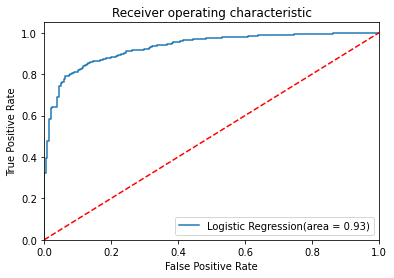

In [368]:
pred_o = model_kfold.predict_proba(X_test)[:,1]
#the roc curve
the_roc_curve(y_test, pred, pred_o, 'Logistic Regression')

#### 2.XGBoost Classifier

In [369]:
#prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
model_xgb = XGBClassifier()
# evaluate model
scores = cross_val_score(model_xgb, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.948 (0.003)


In [370]:
model_xgb.fit(X_train, y_train)
pred_x = model_xgb.predict(X_test)
eval_metrics(y_test, pred_x)


Accuracy: 0.946
Precision: 0.959
Recall: 0.985
F1-Score: 0.971


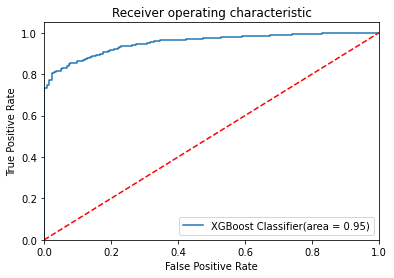

In [371]:
pred_xgb = model_xgb.predict_proba(X_test)[:,1]
#the roc curve
the_roc_curve(y_test, pred_x, pred_xgb, 'XGBoost Classifier')

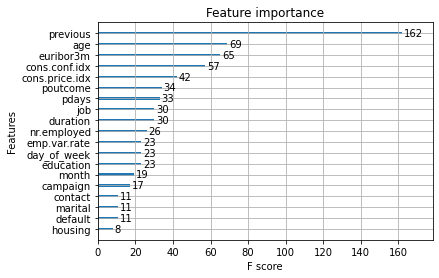

In [382]:
#feature importances
from xgboost import plot_importance
#plot feature importance
plot_importance(model_xgb)
plt.show()

   #### 3.SVM

In [373]:
from sklearn.svm import SVC
kernel = ["linear", "rbf", "poly"]
for i in kernel:
    #prepare the cross-validation procedure
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    # create model
    model = SVC(kernel = i, C = 1.0)
    # evaluate model
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print("for kernel", i)
    print('Cross Validation Score: %.3f (%.3f)' % (mean(scores), std(scores)))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #the evaluation metrics
    eval_metrics(y_test, y_pred)
    

for kernel linear
Cross Validation Score: 0.937 (0.004)
Accuracy: 0.939
Precision: 0.948
Recall: 0.989
F1-Score: 0.968
for kernel rbf
Cross Validation Score: 0.937 (0.004)
Accuracy: 0.940
Precision: 0.948
Recall: 0.989
F1-Score: 0.968
for kernel poly
Cross Validation Score: 0.931 (0.002)
Accuracy: 0.934
Precision: 0.934
Recall: 1.000
F1-Score: 0.966


#### 4.Random Forest

In [374]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
#prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
rfc_model = RandomForestClassifier()
# evaluate model
scores = cross_val_score(rfc_model , X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))



Accuracy: 0.940 (0.002)


Accuracy: 0.939
Precision: 0.959
Recall: 0.976
F1-Score: 0.967


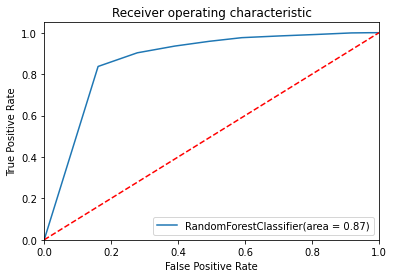

In [375]:
rfc_model.fit(X_train,y_train)
# predictions
rfc_predict = rfc_model.predict(X_test)
rfc_proba = rfc_model.predict_proba(X_test)[:,1]
#the evaluation metrics
eval_metrics(y_test, rfc_predict)
#the roc curve
the_roc_curve(y_test,rfc_predict , rfc_proba, 'RandomForestClassifier')

In [376]:
#feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rfc_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi

,feature,importance
14,poutcome,0.149166
13,previous,0.111803
16,cons.price.idx,0.077920
12,pdays,0.068617
0,age,0.055647
18,euribor3m,0.050180
17,cons.conf.idx,0.047991
19,nr.employed,0.046018
15,emp.var.rate,0.044175
9,day_of_week,0.042612


#### 5.Decision Trees

In [378]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier 
# random forest model creation
#prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
clf_decision_model = DecisionTreeClassifier(criterion="entropy", max_depth=3)
# evaluate model
scores = cross_val_score(clf_decision_model , X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))






Accuracy: 0.939 (0.002)


Accuracy: 0.939
Precision: 0.943
Recall: 0.995
F1-Score: 0.968


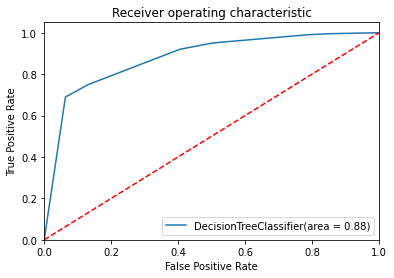

In [379]:
clf_decision_model.fit(X_train, y_train)
# predictions
y_pred = clf_decision_model.predict(X_test)
y_proba = clf_decision_model.predict_proba(X_test)[:,1]
#the evaluation metrics
eval_metrics(y_test, y_pred)
#the roc curve
the_roc_curve(y_test,y_pred , y_proba, 'DecisionTreeClassifier')

In [381]:
fi= pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf_decision_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

fi

,feature,importance
0,age,0.509715
13,previous,0.161575
14,poutcome,0.147556
16,cons.price.idx,0.113387
18,euribor3m,0.067768
1,job,0.000000
17,cons.conf.idx,0.000000
15,emp.var.rate,0.000000
12,pdays,0.000000
11,campaign,0.000000
